In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow




def get_illumination_channel(I):
    M, N, _ = I.shape
    darkch = np.zeros((M, N))
    brightch = np.zeros((M, N))

    for i, j in np.ndindex(darkch.shape):
        darkch[i, j] = np.min(I[i:i + 1, j:j + 1, :])  
        brightch[i, j] = np.max(I[i:i + 1, j:j + 1, :])  

    return darkch, brightch


def get_atmosphere(I, brightch):
    M, N = brightch.shape
    flatI = I.reshape(M * N, 3)  
    flatbright = brightch.ravel()  

    searchidx = (-flatbright).argsort()[:int(M * N * 0.1)] 
    A = np.mean(flatI.take(searchidx, axis=0), dtype=np.float64, axis=0)
    return A


def get_initial_transmission(A, brightch):
    A_c = np.max(A)
    init_t = (brightch - A_c) / (1. - A_c)
    return (init_t - np.min(init_t)) / (np.max(init_t) - np.min(init_t))  


def get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega):
    im = np.empty(I.shape, I.dtype);
    for ind in range(0, 3):
        im[:, :, ind] = I[:, :, ind] / A[ind]  
    dark_c, _ = get_illumination_channel(im)  
    dark_t = 1 - omega * dark_c  
    corrected_t = init_t  
    diffch = brightch - darkch  

    for i in range(diffch.shape[0]):
        for j in range(diffch.shape[1]):
            if (diffch[i, j] < alpha):
                corrected_t[i, j] = dark_t[i, j] * init_t[i, j]

    return np.abs(corrected_t)




def get_final_image(I, A, refined_t, tmin):
    refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None], (
        refined_t.shape[0], refined_t.shape[1], 3))  
    J = (I - A) / (np.where(refined_t_broadcasted < tmin, tmin, refined_t_broadcasted)) + A  

    return (J - np.min(J)) / (np.max(J) - np.min(J))  




def dehaze(I, tmin=0.1, alpha=0.4, omega=0.75):
    I = np.asarray(I, dtype=np.float64)
    I = I[:, :, :3] / 255.
    m, n, _ = I.shape
    Idark, Ibright = get_illumination_channel(I)
    A = get_atmosphere(I, Ibright)

    init_t = get_initial_transmission(A, Ibright)
    corrected_t = get_corrected_transmission(I, A, Idark, Ibright, init_t, alpha, omega)

    normI = (I - I.min()) / (I.max() - I.min())
    J_refined = get_final_image(I, A, corrected_t, tmin)

    enhanced = (J_refined * 255).astype(np.uint8)
    return enhanced


In [ ]:
img = cv2.imread('/content/anh_chup_toi_2.png')
img = dehaze(img)

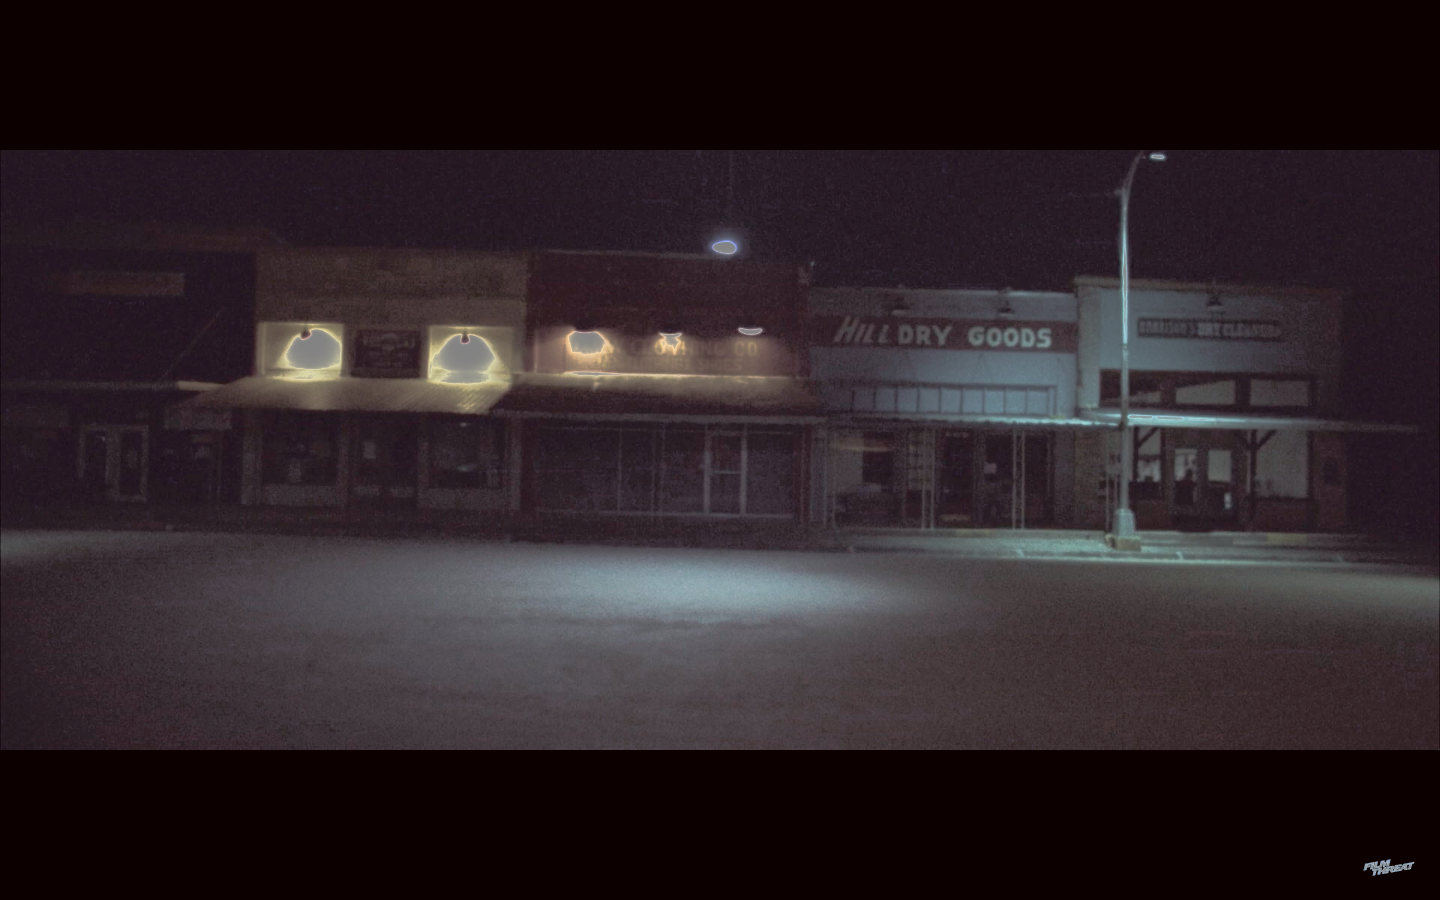

In [ ]:
cv2_imshow(img)